In [1]:
import numpy as np
import os
import re
import pandas as pd
import random
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

def border():
    bwith = 2 #边框宽度设置为2
    ax = plt.gca()#获取边框
    ax.tick_params(axis="x", direction="in", length=16, width=5, color="k")
    ax.tick_params(axis="x", direction="in", length=16, width=5, color="k")
    # ax.spines['top'].set_color('grey')  # 设置上‘脊梁’为红色
    # ax.spines['right'].set_color('grey')  # 设置右‘脊梁’为无色
    # ax.spines['left'].set_color('grey')  # 设置上‘脊梁’为红色
    # ax.spines['bottom'].set_color('none')  # 设置右‘脊梁’为无色
    ax.spines['bottom'].set_linewidth(bwith)
    ax.spines['left'].set_linewidth(bwith)
    ax.spines['top'].set_linewidth(bwith)
    ax.spines['right'].set_linewidth(bwith)

with open("sys",'r') as f:
    sys=f.read()

In [2]:
def get_eval_metric(mtcs, file): # 文件中共有多少次eval，以及最后一次eval的metric值
    i = 0
    metric = '\'acc\': '
    target_str = metric + '\d+.?\d+'
    number_str = '\d+.?\d+'
    for line in open(file,"r"):
        if metric in line:
            word = re.findall(target_str, line)[0]
            mtc = re.findall(number_str, word)[0]
            
            mtcs.append(mtc)
            i = i + 1
    return i, mtcs 

def get_eval_metric_st(mtcs, file): # 文件中共有多少次eval，以及最后一次eval的metric值
    i = 0
    metric = '\'f1_score\': '
    target_str = metric + '\d+.?\d+'
    number_str = '\d+.?\d+'
    for line in open(file,"r"):
        if metric in line:
            # print(line.split()[-1].split('}')[0])
            # word = re.findall(target_str, line)[0]
            # mtc = re.findall(number_str, word)[0]
            mtc = line.split()[-1].split('}')[0]
            mtcs.append(mtc)
            i = i + 1
    return i, mtcs 

def insert_10(left, right):
    l = [left + 1]
    for i in range(left, right):
        if (i - left -1) % 10 == 0 and i != left + 1:
            l.append(i)
    l.append(right)
    return l

def merge_stack(lists):
    for i in range(len(lists)):
        merged_l = []
        l = lists[i]
        for a in l:
            for b in a:
                merged_l.append(b)
        lists[i] = merged_l
    return lists

def cut(x,y,upper_bound_acc):
    x = np.array(x) / 3600 # convert second to hour
    threshold = 0
    delete_y = [t for t in y if t > upper_bound_acc]
    if len(delete_y) > 0:
        if isinstance(y, list):
            threshold = y.index(delete_y[0])
        else:
            threshold = y.tolist().index(delete_y[0])
    else:
        threshold = len(y)
    y = y[:threshold]
    x = x[:threshold]
    return x,y
            
def sum_duration(depth, width, idx, tmp, time, type = "Dyna-A-Freeze", dataset = "20news"):
    if dataset == "20news":
        batch_num = 29
    if dataset == "agnews":
        batch_num = 30
    if dataset == "semeval":
        batch_num = 20
    if dataset == "onto":
        batch_num = 20

    if dataset == "20news" or dataset == "onto":
        latency_tx2_baseline = np.array([0.5325, 0.612, 0.696, 0.791, 0.883, 0.9713, 1.064, 1.156, 1.2465, 1.33, 1.419, 1.51, 1.7])
        latency_tx2_cached = np.array([0.02, 0.09, 0.18, 0.27, 0.36, 0.45, 0.54, 0.63, 0.72, 0.81, 0.90, 0.99, 1.08]) # msl = 256
    else:
        latency_tx2_baseline = np.array([0.5325, 0.612, 0.696, 0.791, 0.883, 0.9713, 1.064, 1.156, 1.2465, 1.33, 1.419, 1.51, 1.7]) / 4
        latency_tx2_cached = np.array([0.02, 0.09, 0.18, 0.27, 0.36, 0.45, 0.54, 0.63, 0.72, 0.81, 0.90, 0.99, 1.08]) / 4# msl = 64
    comm_bert = np.array([0.6, 7.7, 14.8, 21.9, 29.0, 36.0, 43.1, 50.2, 57.3, 64.4, 71.5, 78.6, 109.5]) * 32 / 8 # 这里面没有仅仅freeze embedding的数据
    adapter_para = 0.0125 * width / 8
    comm_adapter =np.array([0.02 + i * adapter_para for i in range(0,13)]) * 4
    
    if type == "BERT" or type == "Freeze":
        latency = latency_tx2_baseline
        comm = comm_bert * 2
    if type == "Q-Freeze": # 使用误差补偿的方法; Quantize Freeze; TODO:混合精度量化
        latency = latency_tx2_baseline
        if depth > 2:
            comm = comm_bert * 2 / 4  # INT8 量化 for depth >= 2
        else:
            comm = comm_bert * 2 / 8  # INT4 量化 for depth < 2
    if type == "Quantize" : # 使用误差补偿的方法; Quantize Freeze; TODO:混合精度量化
        latency = latency_tx2_baseline
        comm = comm_bert * 2 / 4  # INT8 量化
    if type == "A-Freeze" or type == "Dyna-A-Freeze":
        latency = latency_tx2_cached 
        comm = comm_adapter * 2

    comm_tmp = comm[depth]
    duration = 0
    for i in range(0, idx - tmp):
        comp_tmp = latency[depth] * batch_num
        duration = duration + comp_tmp + comm_tmp
        # print(comp_tmp,comm_tmp)
    if len(time) > 0:
        time.append(duration + time[-1])
    else:
        time.append(duration)
    return time


In [3]:
ft = 60 # font size
lw = 8 # line width
marker = ["o", "v", "s", "^", "D", "o"]
# linestyle = ["-", ":", "--", "-.",('loosely dotted', (0, (1, 10)))]
color = ['darkred','darkblue','darkgreen','darkorange','darkviolet']
linestyle = [(0, ()), (0, (3, 1,1,1,1,1)), (0, (4, 1,1,1)), (0, (1, 1)),(0, (2, 4))]
type = ["FT", "FTQ", r"LF$_{oracle}$", r"LFQ$_{oracle}$", sys]

target_acc = 0.99 # for drawing

BERT 43.95175
Quant 12.744250000000001
Freeze 18.5163622222222
Q-Freeze 5.160140000000001
Dyna-A-Freeze 1.341133333333335


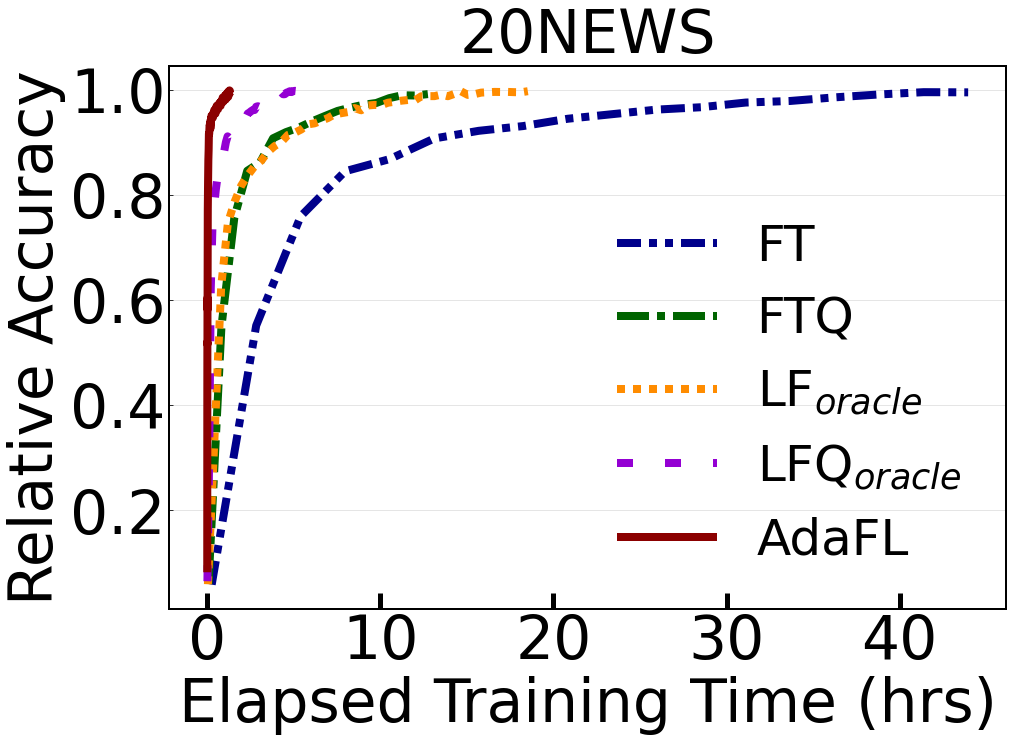

In [4]:
# 20news
root_path = "/Users/cdq/Desktop/opensource/FedFinetuning/"
log_root_path = "data/nice_results/20news-Trail-0-60"
log_file_name = "fednlp_tc_deep_0.log"
file = os.path.join(root_path, log_root_path, log_file_name)


# depth, width, round, metric
dwrm = [[0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3], [8, 8, 8, 16, 16, 16, 24, 32, 32, 32, 40, 48, 48, 48, 56, 64, 64, 64, 64, 64], [-1, 79, 88, 180, 272, 364, 453, 539, 625, 711, 794, 875, 956, 1037, 1115, 1191, 1267, 1343, 1393, 1467], [0, '0.4681359532660648', '0.602761550716941', '0.7422995220392989', '0.7559745087626129', '0.7636749867233139', '0.7684545937334042', '0.7729686670207117', '0.7804036112586299', '0.7838555496548062', '0.7892989909718534', '0.7934147636749868', '0.7954062665958577', '0.7966011683483802', '0.7980616038236856', '0.8005841741901222', '0.8029739776951673', '0.8016463090812533', '0.8020446096654275', '0.8031067445565587']]


flag = ["init"]
trial_num = len(dwrm[0])
for i in range(trial_num-1):
    depth = dwrm[0]
    width = dwrm[1]
    if depth[i+1] > depth[i]: # deeper
        flag.append("deep")
    elif width[i+1] > width[i]: # wider
        flag.append("wide")
    else:
        flag.append("shallow")
dwrm.append(flag)

new_dwrm = [[],[],[],[]]
for i in range(1, trial_num):
    mtcs = [] # metric
    log_file_name = "fednlp_tc_" + dwrm[-1][i] + "_" + str(i-1) + ".log"
    file = os.path.join(root_path, log_root_path, log_file_name)
    count, mtcs = get_eval_metric(mtcs, file)
    new_dwrm[0].append([dwrm[0][i]] * count)
    new_dwrm[1].append([dwrm[1][i]] * count)
    new_dwrm[2].append(insert_10(dwrm[2][i-1], dwrm[2][i]))
    new_dwrm[3].append(mtcs) # mtcs是对的，其它不知道
# print(new_dwrm)

merged_new_dwrm = merge_stack(new_dwrm)
# print(merged_new_dwrm)
# for depth in dwrm:

Origin = os.path.join(root_path,"data/Baseline/20news_uniform_lr=0.1_freeze=_quantize=False_adapter=False_MSL=256_workers15_rounds10.txt")
Quant = os.path.join(root_path,"data/Baseline/20news_uniform_lr=0.1_freeze=_quantize=True_adapter=False_MSL=256_workers15_rounds10.txt")
Q_Freeze = os.path.join(root_path,"data/Baseline/20news_uniform_lr=0.1_freeze=e,0,1,2,3,4,5,6,7,8,9_quantize=True_adapter=False_MSL=256_workers15_rounds10.txt")
Freeze = os.path.join(root_path,"data/Baseline/20news_uniform_lr=0.1_freeze=e,0,1,2,3,4,5,6,7,8,9_quantize=False_adapter=False_MSL=256_workers15_rounds10.txt")
def load_baseline(depth, file):
    baseline = []
    for line in open(file,"r"):
        baseline.append(float(line))
    baseline_len = len(baseline)
    baseline_drm = [[depth]*baseline_len, (np.array(range(0, baseline_len))*10).tolist(), baseline]
    return baseline_drm
baseline_origin_drm = load_baseline(12, Origin)
baseline_quant = load_baseline(12, Quant)
baseline_q_freeze_drm = load_baseline(2, Q_Freeze)
baseline_freeze_drm = load_baseline(2, Freeze)

plt.figure(figsize=(15,10))
plt.title("20NEWS",fontsize=ft)
# 设置刻度字体大小
plt.xticks(fontsize=ft)
plt.yticks(fontsize=ft)
plt.xlabel("Elapsed Training Time (hrs)", fontsize=ft)
plt.ylabel("Relative Accuracy", fontsize=ft)
plt.grid(color = 'k', linestyle = (0, (1, 1)), axis="y", linewidth = 0.5, alpha=0.4)
border()

x_major_locator=MultipleLocator(10)
y_major_locator=MultipleLocator(0.2)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)

max_acc = 0.8
max_acc = max_acc * target_acc


time = []
tmp = -1 # 记录最后一个访问的idx
data = baseline_origin_drm
y = [float(i) for i in baseline_origin_drm[2]]
for idx in data[1]:
    id = data[1].index(idx)
    d = data[0][id]
    w = 0
    time = sum_duration(d, w, idx, tmp, time, "BERT", "20news")
    tmp = idx

time, y = cut(time, y, max_acc)
plt.plot(np.array(time), np.array(y)/max_acc, label = type[0], linewidth = lw, color = color[1], linestyle = linestyle[1])
print("BERT",time[-1])


time = []
tmp = -1 # 记录最后一个访问的idx
data = baseline_quant
y = [float(i) for i in baseline_quant[2]]
for idx in data[1]:
    id = data[1].index(idx)
    d = data[0][id]
    w = 0
    time = sum_duration(d, w, idx, tmp, time, "Quantize", "20news")
    tmp = idx

time, y = cut(time, y, max_acc)
plt.plot(np.array(time), np.array(y)/max_acc, label = type[1], linewidth = lw, color = color[2], linestyle = linestyle[2])
print("Quant",time[-1])


time = []
tmp = -1 # 记录最后一个访问的idx
data = baseline_freeze_drm
y = [float(i) for i in baseline_freeze_drm[2]]
for idx in data[1]:
    id = data[1].index(idx)
    d = data[0][id]
    w = 0
    time = sum_duration(d, w, idx, tmp, time, "Freeze", "20news")
    tmp = idx

time, y = cut(time, y, max_acc)
plt.plot(np.array(time), np.array(y)/max_acc, label = type[2], linewidth = lw, color = color[3], linestyle = linestyle[3])
print("Freeze",time[-1])

time = []
tmp = -1 # 记录最后一个访问的idx
data = baseline_q_freeze_drm
y = [float(i) for i in baseline_q_freeze_drm[2]]
for idx in data[1]:
    id = data[1].index(idx)
    d = data[0][id]
    w = 0
    time = sum_duration(d, w, idx, tmp, time, "Q-Freeze", "20news")
    tmp = idx

time, y = cut(time, y, max_acc)
plt.plot(np.array(time), np.array(y)/max_acc, label = type[3], linewidth = lw, color = color[4], linestyle = linestyle[4])
print("Q-Freeze",time[-1])

time = []
data = new_dwrm
tmp = -1 # 记录最后一个访问的idx
y = [float(i) for i in data[3]]
for idx in data[2]:
    id = data[2].index(idx)
    d = data[0][id]
    w = data[1][id]
    time = sum_duration(d, w, idx, tmp, time, "Dyna-A-Freeze", "20news")
    tmp = idx

time, y = cut(time, y, max_acc)
plt.plot(np.array(time), np.array(y)/max_acc, label = type[4], linewidth = lw, color = color[0], linestyle = linestyle[0])
print("Dyna-A-Freeze",time[-1])

plt.legend(fontsize=50,ncol = 1,frameon=False)
if target_acc >= 0.99:
    plt.savefig('../figs/eval-performance-bert-20news.pdf', bbox_inches="tight")

BERT 31.10625
Quant 9.076875
Freeze 9.64922777777778
Q-Freeze 1.5626722222222214
Dyna-A-Freeze 0.24080972222222238


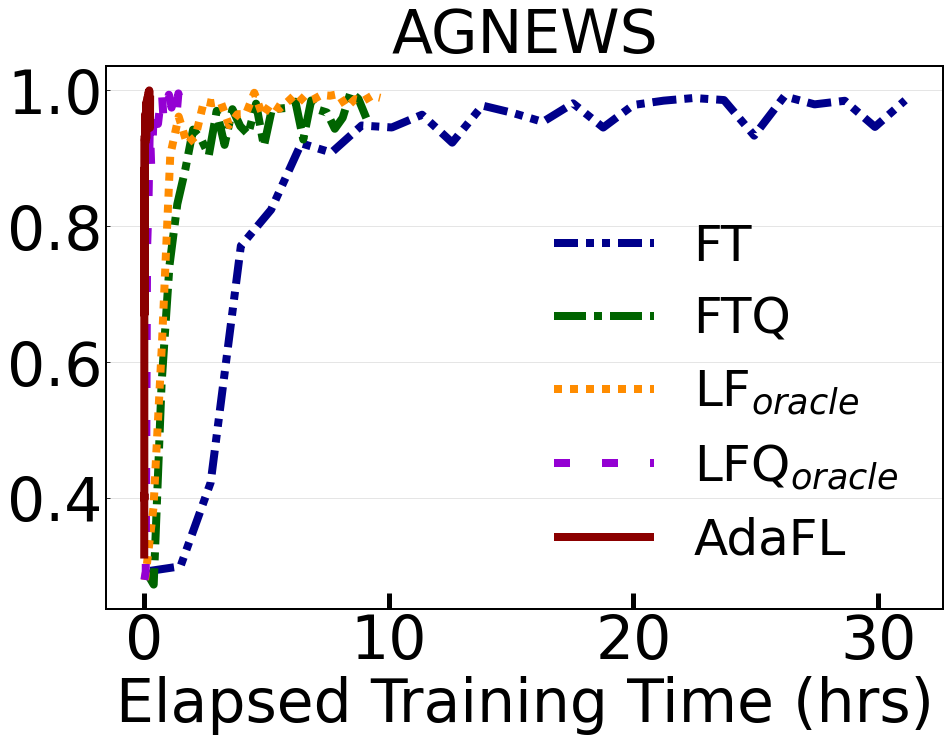

In [5]:
# agnews
root_path = "/Users/cdq/Desktop/opensource/FedFinetuning/"
log_root_path = "data/nice_results/agnews-Trail-0-90"
log_file_name = "fednlp_tc_deep_0.log"
file = os.path.join(root_path, log_root_path, log_file_name)
ft = 60 # font size

# real result 2.0
dwrm = [[0, 0, 0, 2, 2, 2, 3, 3, 3, 4, 4, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6], [8, 16, 16, 16, 24, 24, 24, 24, 24, 24, 32, 32, 40, 40, 40, 48, 48, 48, 56, 64, 64, 72], [-1, 116, 233, 247, 377, 507, 594, 720, 846, 941, 1061, 1157, 1272, 1387, 1502, 1614, 1726, 1819, 1927, 2032, 2137, 2242], [0, '0.7171052631578947', '0.8127631578947369', '0.8092105263157895', '0.8567105263157895', '0.8693421052631579', '0.8747368421052631', '0.8744736842105263', '0.8794736842105263', '0.8806578947368421', '0.8825', '0.886578947368421', '0.891578947368421', '0.8927631578947368', '0.8956578947368421', '0.8992105263157895', '0.8997368421052632', '0.9021052631578947', '0.9031578947368422', '0.9028947368421053', '0.9032894736842105', '0.906578947368421']]

flag = ["init"]
trial_num = len(dwrm[0])
for i in range(trial_num-1):
    depth = dwrm[0]
    width = dwrm[1]
    if depth[i+1] > depth[i]: # deeper
        flag.append("deep")
    elif width[i+1] > width[i]: # wider
        flag.append("wide")
    else:
        flag.append("shallow")
dwrm.append(flag)

new_dwrm = [[],[],[],[]]
for i in range(1, trial_num):
    mtcs = [] # metric
    log_file_name = "fednlp_tc_" + dwrm[-1][i] + "_" + str(i-1) + ".log"
    file = os.path.join(root_path, log_root_path, log_file_name)
    count, mtcs = get_eval_metric(mtcs, file)
    new_dwrm[0].append([dwrm[0][i]] * count)
    new_dwrm[1].append([dwrm[1][i]] * count)
    new_dwrm[2].append(insert_10(dwrm[2][i-1], dwrm[2][i]))
    new_dwrm[3].append(mtcs) # mtcs是对的，其它不知道
# print(new_dwrm)

merged_new_dwrm = merge_stack(new_dwrm)
# print(merged_new_dwrm)
# for depth in dwrm:

Origin = os.path.join(root_path,"data/Baseline/agnews_niid_label_clients=1000_alpha=10.0_lr=0.1_freeze=_quantize=False_adapter=False_length=64.txt")
Quant = os.path.join(root_path,"data/Baseline/agnews_niid_label_clients=1000_alpha=10.0_lr=0.1_freeze=_quantize=True_adapter=False_length=64.txt")
Q_Freeze = os.path.join(root_path,"data/Baseline/agnews_niid_label_clients=1000_alpha=10.0_lr=0.1_freeze=e,0,1,2,3,4,5,6,7,8,9_quantize=True_adapter=False_MSL=64_workers15_rounds10.txt")
Freeze = os.path.join(root_path,"data/Baseline/agnews_niid_label_clients=1000_alpha=10.0_lr=0.1_freeze=e,0,1,2,3,4,5,6,7,8,9_quantize=False_adapter=False_MSL=64_workers15_rounds10.txt")
def load_baseline(depth, file):
    baseline = []
    for line in open(file,"r"):
        baseline.append(float(line))
    baseline_len = len(baseline)
    baseline_drm = [[depth]*baseline_len, (np.array(range(0, baseline_len))*5).tolist(), baseline]
    return baseline_drm
baseline_origin_drm = load_baseline(12, Origin)
baseline_quant = load_baseline(12, Quant)
def load_baseline(depth, file):
    baseline = []
    for line in open(file,"r"):
        baseline.append(float(line))
    baseline_len = len(baseline)
    baseline_drm = [[depth]*baseline_len, (np.array(range(0, baseline_len))*10).tolist(), baseline]
    return baseline_drm
baseline_q_freeze_drm = load_baseline(2, Q_Freeze)
baseline_freeze_drm = load_baseline(2, Freeze)
# print(baseline_quant)

# agnews plot
plt.figure(figsize=(15,10))
plt.title("AGNEWS",fontsize=ft)
# 设置刻度字体大小
plt.xticks(fontsize=ft)
plt.yticks(fontsize=ft)
plt.xlabel("Elapsed Training Time (hrs)", fontsize=ft)
# plt.ylabel("Accuracy", fontsize=ft)
plt.grid(color = 'k', linestyle = (0, (1, 1)), axis="y", linewidth = 0.5, alpha=0.4)
border()

x_major_locator=MultipleLocator(10)
y_major_locator=MultipleLocator(0.2)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)

max_acc = 0.88
max_acc = max_acc * target_acc


time = []
tmp = -1 # 记录最后一个访问的idx
data = baseline_origin_drm
y = [float(i) for i in baseline_origin_drm[2]]
for idx in data[1]:
    id = data[1].index(idx)
    d = data[0][id]
    w = 0
    time = sum_duration(d, w, idx, tmp, time, "BERT", "agnews")
    tmp = idx

time, y = cut(time, y, max_acc)
plt.plot(np.array(time), np.array(y)/max_acc, label = type[0], linewidth = lw, color = color[1], linestyle = linestyle[1])
print("BERT",time[-1])


time = []
tmp = -1 # 记录最后一个访问的idx
data = baseline_quant
y = [float(i) for i in baseline_quant[2]]
for idx in data[1]:
    id = data[1].index(idx)
    d = data[0][id]
    w = 0
    time = sum_duration(d, w, idx, tmp, time, "Quantize", "agnews")
    tmp = idx

time, y = cut(time, y, max_acc)
plt.plot(np.array(time), np.array(y)/max_acc, label = type[1], linewidth = lw, color = color[2], linestyle = linestyle[2])
print("Quant",time[-1])

time = []
tmp = -1 # 记录最后一个访问的idx
data = baseline_freeze_drm
y = [float(i) for i in baseline_freeze_drm[2]]
for idx in data[1]:
    id = data[1].index(idx)
    d = data[0][id]
    w = 0
    time = sum_duration(d, w, idx, tmp, time, "Freeze", "agnews")
    tmp = idx

time, y = cut(time, y, max_acc)
plt.plot(np.array(time), np.array(y)/max_acc, label = type[2], linewidth = lw, color = color[3], linestyle = linestyle[3])
print("Freeze",time[-1])


time = []
tmp = -1 # 记录最后一个访问的idx
data = baseline_q_freeze_drm
y = [float(i) for i in baseline_q_freeze_drm[2]]
for idx in data[1]:
    id = data[1].index(idx)
    d = data[0][id]
    w = 0
    time = sum_duration(d, w, idx, tmp, time, "Q-Freeze", "agnews")
    tmp = idx

time, y = cut(time, y, max_acc)
plt.plot(np.array(time), np.array(y)/max_acc, label = type[3], linewidth = lw, color = color[4], linestyle = linestyle[4])
print("Q-Freeze",time[-1])


time = []
data = new_dwrm
tmp = -1 # 记录最后一个访问的idx
y = [float(i) for i in data[3]]
for idx in data[2]:
    id = data[2].index(idx)
    d = data[0][id]
    w = data[1][id]
    time = sum_duration(d, w, idx, tmp, time, "Dyna-A-Freeze", "agnews")
    tmp = idx

time, y = cut(time, y, max_acc)
plt.plot(np.array(time), np.array(y)/max_acc, label = type[4], linewidth = lw, color = color[0], linestyle = linestyle[0])
print("Dyna-A-Freeze",time[-1])


plt.legend(fontsize=50,ncol = 1,frameon=False)
if target_acc >= 0.99:
    plt.savefig('../figs/eval-performance-bert-agnews.pdf', bbox_inches="tight")

BERT 124.32138888888889
Quant 31.976388888888888
Freeze 74.0114777777779
Q-Freeze 16.80408888888887
Dyna-A-Freeze 2.331736111111116


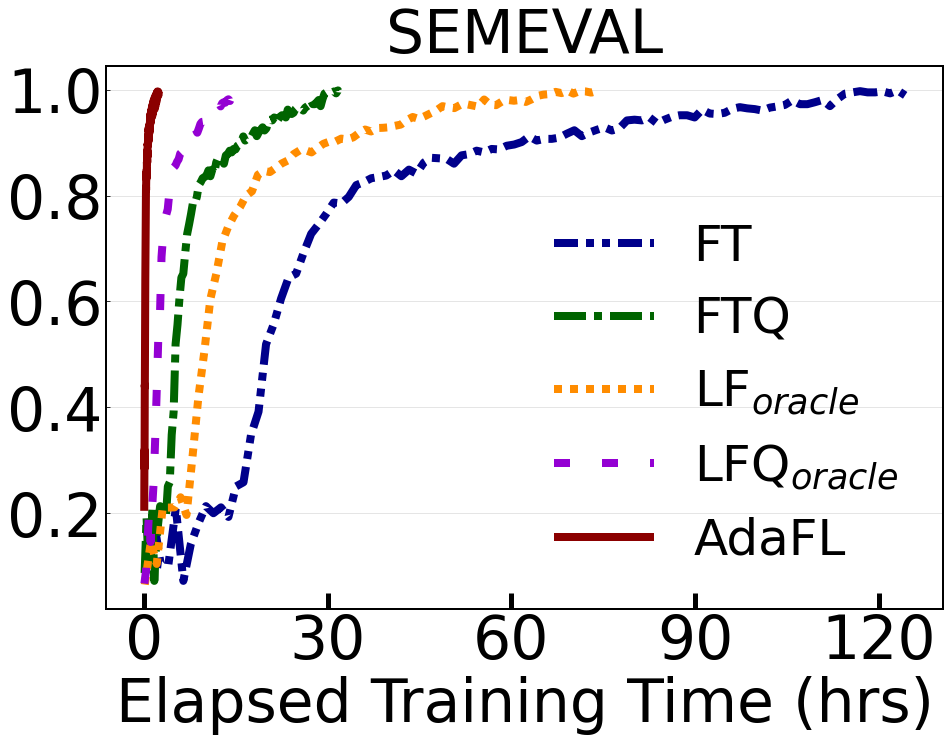

In [6]:
# semeval v3.0
root_path = "/Users/cdq/Desktop/opensource/FedFinetuning/"
log_root_path = "data/nice_results/semeval_2010_task8-Trail-1-90"
log_file_name = "semeval_2010_task8-depth-0-freq-90.log"
file = os.path.join(root_path, log_root_path, log_file_name)
ft = 60 # font size

# 
dwrm = [[1, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 9, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12], [8, 16, 16, 16, 16, 16, 16, 16, 16, 24, 32, 32, 32, 32, 32, 40, 48, 48, 48, 56, 56, 56, 56], [-1, 206, 249, 434, 619, 804, 989, 1174, 1359, 1535, 1703, 1871, 1964, 2088, 2253, 2410, 2561, 2712, 2863, 3008, 3153, 3298, 3443],
[0, '0.2528524107471476', '0.3257269046742731', '0.6352594773647405', '0.6838424733161576', '0.7143908722856092', '0.7364740522635259', '0.7534044902465955', '0.7603974972396025', '0.7684946632315053', '0.7762237762237763', '0.7813765182186235', '0.7854251012145749', '0.7894736842105263', '0.7994111152005889', '0.805668016194332', '0.805668016194332', '0.8100846521899153', '0.8100846521899153', '0.8141332351858668', '0.8185498711814502', '0.8181818181818182', '0.819654030180346']]

flag = ["init"]
trial_num = len(dwrm[0])
for i in range(trial_num-1):
    depth = dwrm[0]
    width = dwrm[1]
    if depth[i+1] > depth[i]: # deeper
        flag.append("deep")
    elif width[i+1] > width[i]: # wider
        flag.append("wide")
    else:
        flag.append("shallow")
dwrm.append(flag)

new_dwrm = [[],[],[],[]]
for i in range(1, trial_num):
    mtcs = [] # metric
    log_file_name = "fednlp_tc_" + dwrm[-1][i] + "_" + str(i-1) + ".log"
    file = os.path.join(root_path, log_root_path, log_file_name)
    count, mtcs = get_eval_metric(mtcs, file)
    new_dwrm[0].append([dwrm[0][i]] * count)
    new_dwrm[1].append([dwrm[1][i]] * count)
    new_dwrm[2].append(insert_10(dwrm[2][i-1], dwrm[2][i]))
    new_dwrm[3].append(mtcs) # mtcs是对的，其它不知道
# print(new_dwrm)

merged_new_dwrm = merge_stack(new_dwrm)
# print(merged_new_dwrm)
# for depth in dwrm:

Origin = os.path.join(root_path,"data/Baseline/semeval_2010_task8_niid_label_clients=100_alpha=100_lr=0.1_freeze=_quantize=False_adapter=False_length=64.txt")
Quant = os.path.join(root_path,"data/Baseline/semeval_2010_task8_niid_label_clients=100_alpha=100_lr=0.1_freeze=_quantize=True_adapter=False_length=64.txt")
Q_Freeze = os.path.join(root_path,"data/Baseline/semeval_2010_task8_niid_label_clients=100_alpha=100_lr=0.1_freeze=e,0,1,2,3,4,5_quantize=True_adapter=False_MSL=64_workers15_rounds10.txt")
Freeze = os.path.join(root_path,"data/Baseline/semeval_2010_task8_niid_label_clients=100_alpha=100_lr=0.1_freeze=e,0,1,2,3,4,5_quantize=False_adapter=False_MSL=64_workers15_rounds10.txt")
def load_baseline(depth, file):
    baseline = []
    for line in open(file,"r"):
        baseline.append(float(line))
    baseline_len = len(baseline)
    baseline_drm = [[depth]*baseline_len, (np.array(range(0, baseline_len))*5).tolist(), baseline]
    return baseline_drm
baseline_origin_drm = load_baseline(12, Origin)
baseline_quant = load_baseline(12, Quant)
def load_baseline(depth, file):
    baseline = []
    for line in open(file,"r"):
        baseline.append(float(line))
    baseline_len = len(baseline)
    baseline_drm = [[depth]*baseline_len, (np.array(range(0, baseline_len))*10).tolist(), baseline]
    return baseline_drm
baseline_q_freeze_drm = load_baseline(6, Q_Freeze)
baseline_freeze_drm = load_baseline(6, Freeze)

# agnews plot
plt.figure(figsize=(15,10))
plt.title("SEMEVAL",fontsize=ft)
# 设置刻度字体大小
plt.xticks(fontsize=ft)
plt.yticks(fontsize=ft)
plt.xlabel("Elapsed Training Time (hrs)", fontsize=ft)
# plt.ylabel("Accuracy", fontsize=ft)
plt.grid(color = 'k', linestyle = (0, (1, 1)), axis="y", linewidth = 0.5, alpha=0.4)
border()

x_major_locator=MultipleLocator(30)
y_major_locator=MultipleLocator(0.2)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)

max_acc = 0.8
max_acc = max_acc * target_acc


time = []
tmp = -1 # 记录最后一个访问的idx
data = baseline_origin_drm
y = [float(i) for i in baseline_origin_drm[2]]
for idx in data[1]:
    id = data[1].index(idx)
    d = data[0][id]
    w = 0
    time = sum_duration(d, w, idx, tmp, time, "BERT", "semeval")
    tmp = idx

time, y = cut(time, y, max_acc)
plt.plot(np.array(time), np.array(y)/max_acc, label = type[0], linewidth = lw, color = color[1], linestyle = linestyle[1])
print("BERT",time[-1])


time = []
tmp = -1 # 记录最后一个访问的idx
data = baseline_quant
y = [float(i) for i in baseline_origin_drm[2]]
for idx in data[1]:
    id = data[1].index(idx)
    d = data[0][id]
    w = 0
    time = sum_duration(d, w, idx, tmp, time, "Quantize", "semeval")
    tmp = idx

time, y = cut(time, y, max_acc)
plt.plot(np.array(time), np.array(y)/max_acc, label = type[1], linewidth = lw, color = color[2], linestyle = linestyle[2])
print("Quant",time[-1])

time = []
tmp = -1 # 记录最后一个访问的idx
data = baseline_freeze_drm
y = [float(i) for i in baseline_freeze_drm[2]]
for idx in data[1]:
    id = data[1].index(idx)
    d = data[0][id]
    w = 0
    time = sum_duration(d, w, idx, tmp, time, "Freeze", "semeval")
    tmp = idx

time, y = cut(time, y, max_acc)
plt.plot(np.array(time), np.array(y)/max_acc, label = type[2], linewidth = lw, color = color[3], linestyle = linestyle[3])
print("Freeze",time[-1])


time = []
tmp = -1 # 记录最后一个访问的idx
data = baseline_q_freeze_drm
y = [float(i) for i in baseline_q_freeze_drm[2]]
for idx in data[1]:
    id = data[1].index(idx)
    d = data[0][id]
    w = 0
    time = sum_duration(d, w, idx, tmp, time, "Q-Freeze", "semeval")
    tmp = idx

time, y = cut(time, y, max_acc)
plt.plot(np.array(time), np.array(y)/max_acc, label = type[3], linewidth = lw, color = color[4], linestyle = linestyle[4])
print("Q-Freeze",time[-1])


time = []
data = new_dwrm
tmp = -1 # 记录最后一个访问的idx
y = [float(i) for i in data[3]]
for idx in data[2]:
    id = data[2].index(idx)
    d = data[0][id]
    w = data[1][id]
    time = sum_duration(d, w, idx, tmp, time, "Dyna-A-Freeze", "semeval")
    tmp = idx

time, y = cut(time, y, max_acc)
plt.plot(np.array(time), np.array(y)/max_acc, label = type[4], linewidth = lw, color = color[0], linestyle = linestyle[0])
print("Dyna-A-Freeze",time[-1])


plt.legend(fontsize=50,ncol = 1,frameon=False)
if target_acc >= 0.99:
    plt.savefig('../figs/eval-performance-bert-semeval.pdf', bbox_inches="tight")

BERT 76.08611111111111
Quant 21.15361111111111
Freeze 82.46968888888878
Q-Freeze 23.914300000000036
Dyna-A-Freeze 4.504472222222231


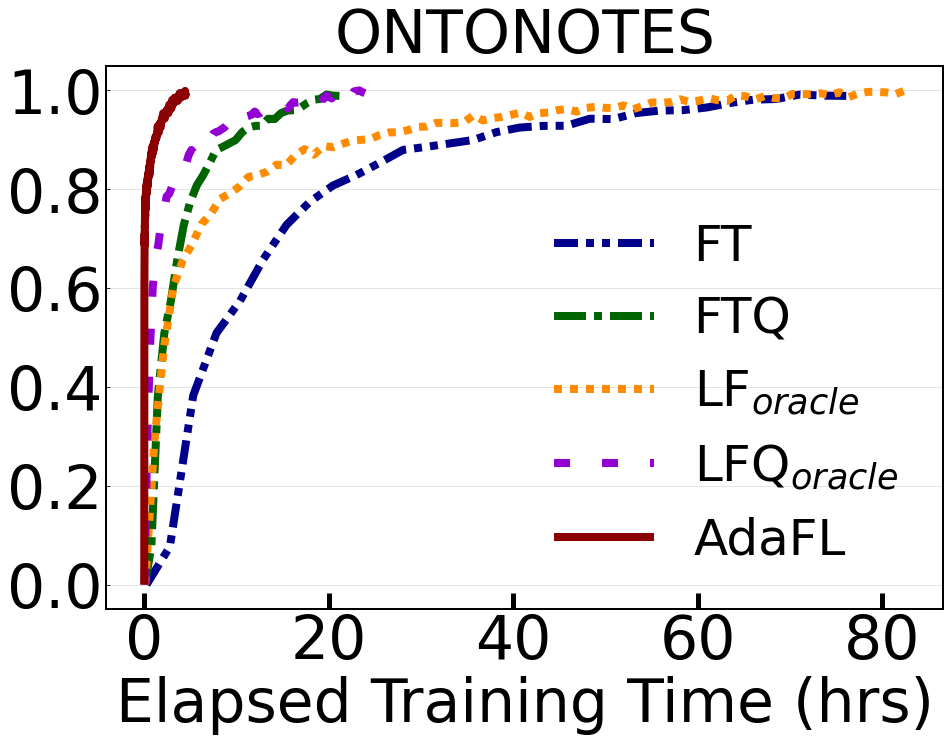

In [7]:
# onto
root_path = "/Users/cdq/Desktop/opensource/FedFinetuning/"
log_root_path = "data/nice_results/onto-Trail-1-100"
log_file_name = "fednlp_tc_deep_0.log"
file = os.path.join(root_path, log_root_path, log_file_name)
ft = 60 # font size

# 
dwrm = [[1, 1, 1, 1, 1, 1, 5, 5, 5, 5, 9, 9, 12, 12, 12, 12, 12, 12, 12], [8, 8, 16, 24, 24, 32, 32, 32, 32, 40, 40, 40, 40, 48, 56, 56, 56, 64, 72], [-1, 240, 470, 690, 910, 1120, 1163, 1350, 1537, 1716, 1815, 1991, 2123, 2291, 2452, 2613, 2774, 2929, 3084],
[0, '0.5275039583226928', '0.5616751017167807', '0.5828858564461303', '0.591306972532448', '0.6005060728744939', '0.6078450745973718', '0.6285714285714286', '0.6495439025633185', '0.6629558341569994', '0.6721102322020924', '0.6921341239439576', '0.7079159096807683', '0.7206368899917287', '0.731308043444042', '0.7382902751522789', '0.7469370511195607', '0.7527915798471976', '0.7577876668785759']]

flag = ["init"]
trial_num = len(dwrm[0])
for i in range(trial_num-1):
    depth = dwrm[0]
    width = dwrm[1]
    if depth[i+1] > depth[i]: # deeper
        flag.append("deep")
    elif width[i+1] > width[i]: # wider
        flag.append("wide")
    else:
        flag.append("shallow")
dwrm.append(flag)

new_dwrm = [[],[],[],[]]
for i in range(1, trial_num):
    mtcs = [] # metric
    log_file_name = "fednlp_tc_" + dwrm[-1][i] + "_" + str(i-1) + ".log"
    file = os.path.join(root_path, log_root_path, log_file_name)
    count, mtcs = get_eval_metric_st(mtcs, file)
    new_dwrm[0].append([dwrm[0][i]] * count)
    new_dwrm[1].append([dwrm[1][i]] * count)
    new_dwrm[2].append(insert_10(dwrm[2][i-1], dwrm[2][i]))
    new_dwrm[3].append(mtcs) # mtcs是对的，其它不知道
# print(new_dwrm)

merged_new_dwrm = merge_stack(new_dwrm)
# print(merged_new_dwrm)
# for depth in dwrm:

Origin = os.path.join(root_path,"data/Baseline/onto_niid_label_clients=30_alpha=1.0_lr=0.1_freeze=_quantize=False_adapter=False_MSL=256_workers15_rounds10.txt")
Quant = os.path.join(root_path,"data/Baseline/onto_niid_label_clients=30_alpha=1.0_lr=0.1_freeze=_quantize=True_adapter=False_MSL=256_workers15_rounds10.txt")
Q_Freeze = os.path.join(root_path,"data/Baseline/onto_niid_label_clients=30_alpha=1.0_lr=0.1_freeze=e,0,1,2,3,4,5_quantize=False_adapter=False_MSL=256_workers15_rounds10.txt")
Freeze = os.path.join(root_path,"data/Baseline/onto_niid_label_clients=30_alpha=1.0_lr=0.1_freeze=e,0,1,2,3,4,5_quantize=True_adapter=False_MSL=256_workers15_rounds10.txt")
def load_baseline(depth, file):
    baseline = []
    for line in open(file,"r"):
        baseline.append(float(line))
    baseline_len = len(baseline)
    baseline_drm = [[depth]*baseline_len, (np.array(range(0, baseline_len))*10).tolist(), baseline]
    return baseline_drm
baseline_origin_drm = load_baseline(12, Origin)
baseline_quant = load_baseline(12, Quant)
# baseline_q_freeze_drm = load_baseline(6, Q_Freeze)
# 对应table2，此处应该至少是8
baseline_q_freeze_drm = load_baseline(6, Q_Freeze)
baseline_freeze_drm = load_baseline(6, Freeze)


# agnews plot
plt.figure(figsize=(15,10))
plt.title("ONTONOTES",fontsize=ft)
# 设置刻度字体大小
plt.xticks(fontsize=ft)
plt.yticks(fontsize=ft)
plt.xlabel("Elapsed Training Time (hrs)", fontsize=ft)
# plt.ylabel("Token-F1", fontsize=ft)
plt.grid(color = 'k', linestyle = (0, (1, 1)), axis="y", linewidth = 0.5, alpha=0.4)
# plt.ylim(0.0001,1.05)
border()

x_major_locator=MultipleLocator(20)
y_major_locator=MultipleLocator(0.2)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)

max_acc = 0.75
max_acc = max_acc * target_acc


time = []
tmp = -1 # 记录最后一个访问的idx
data = baseline_origin_drm
y = [float(i) for i in baseline_origin_drm[2]]
for idx in data[1]:
    id = data[1].index(idx)
    d = data[0][id]
    w = 0
    time = sum_duration(d, w, idx, tmp, time, "BERT", "onto")
    tmp = idx

time, y = cut(time, y, max_acc)
plt.plot(np.array(time), np.array(y)/max_acc, label = type[0], linewidth = lw, color = color[1], linestyle = linestyle[1])
print("BERT",time[-1])


time = []
tmp = -1 # 记录最后一个访问的idx
data = baseline_origin_drm
y = [float(i) for i in baseline_origin_drm[2]]
for idx in data[1]:
    id = data[1].index(idx)
    d = data[0][id]
    w = 0
    time = sum_duration(d, w, idx, tmp, time, "Quantize", "onto")
    tmp = idx

time, y = cut(time, y, max_acc)
plt.plot(np.array(time), np.array(y)/max_acc, label = type[1], linewidth = lw, color = color[2], linestyle = linestyle[2])
print("Quant",time[-1])

time = []
tmp = -1 # 记录最后一个访问的idx
data = baseline_freeze_drm
y = [float(i) for i in baseline_freeze_drm[2]]
for idx in data[1]:
    id = data[1].index(idx)
    d = data[0][id]
    w = 0
    time = sum_duration(d, w, idx, tmp, time, "Freeze", "onto")
    tmp = idx

time, y = cut(time, y, max_acc)
plt.plot(np.array(time), np.array(y)/max_acc, label = type[2], linewidth = lw, color = color[3], linestyle = linestyle[3])
print("Freeze",time[-1])


time = []
tmp = -1 # 记录最后一个访问的idx
data = baseline_q_freeze_drm
y = [float(i) for i in baseline_q_freeze_drm[2]]
for idx in data[1]:
    id = data[1].index(idx)
    d = data[0][id]
    w = 0
    time = sum_duration(d, w, idx, tmp, time, "Q-Freeze", "onto")
    tmp = idx

time, y = cut(time, y, max_acc)
plt.plot(np.array(time), np.array(y)/max_acc, label = type[3], linewidth = lw, color = color[4], linestyle = linestyle[4])
print("Q-Freeze",time[-1])

time = []
data = new_dwrm
tmp = -1 # 记录最后一个访问的idx
y = [float(i) for i in data[3]]
for idx in data[2]:
    id = data[2].index(idx)
    d = data[0][id]
    w = data[1][id]
    time = sum_duration(d, w, idx, tmp, time, "Dyna-A-Freeze", "semeval")
    tmp = idx

time, y = cut(time, y, max_acc)
plt.plot(np.array(time), np.array(y)/max_acc, label = type[4], linewidth = lw, color = color[0], linestyle = linestyle[0])
print("Dyna-A-Freeze",time[-1])

plt.legend(fontsize=50,ncol = 1,frameon=False)
if target_acc >= 0.99:
    plt.savefig('../figs/eval-performance-bert-onto.pdf', bbox_inches="tight")